# Estimacion de parámetros usando Stan en Python

Cristian Guarnizo-Lemus, PhD. Tratamiento Matemático. Instituto Tecnólogico Metropolitano.

Este notebook es basado en el ejemplo publicado en [Link](https://towardsdatascience.com/an-introduction-to-bayesian-inference-in-pystan-c27078e58d53). Empezamos importando las librerias que se emplearan en este ejemplo.

In [0]:
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

sns.set()  # Graficas bonitas

Generacion de datos del modelo <br>
$y_n = \alpha + \beta x_n + \epsilon_n$ <br>
donde $\epsilon \sim \mathcal{N}(0,\sigma)$ e iid.



In [0]:
np.random.seed(101)

# Parametros a inferir
alpha = 4.0
beta = 0.5
sigma = 1.0

# Generar datos
x = 10 * np.random.rand(100)
y = alpha + beta * x
y = np.random.normal(y, scale=sigma)


Grafica de los datos en un scatter plot

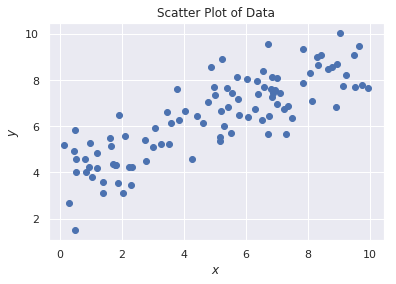

In [16]:
plt.scatter(x, y)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Scatter Plot of Data')

plt.show()

Definición del modelo probabilistico en Stan.

In [0]:
model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(alpha + beta * x, sigma);
}
"""

Compilacion del modelo en Stan.

In [6]:
# Poner datos en un diccionario
data = {'N': len(x), 'x': x, 'y': y}

# Compilar el model
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cb4cc9c2a04d0e34d711077557307fb7 NOW.


## Muestreo del modelo en Stan

In [0]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101,
                  verbose=True)

Paso de resultados de Stan a Pandas para realizar analisis.

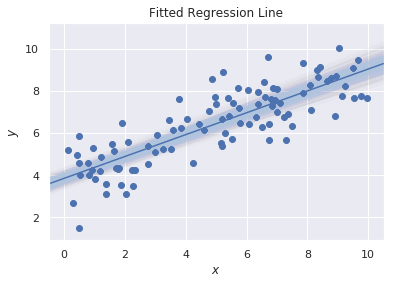

In [10]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']

# Extracting traces
alpha = fit['alpha']
beta = fit['beta']
sigma = fit['sigma']
lp = fit['lp__']

# Plotting regression line
x_min, x_max = -0.5, 10.5
x_plot = np.linspace(x_min, x_max, 100)

# Plot a subset of sampled regression lines
np.random.shuffle(alpha), np.random.shuffle(beta)
for i in range(1000):
  plt.plot(x_plot, alpha[i] + beta[i] * x_plot, color='lightsteelblue', 
           alpha=0.005 )

# Plot mean regression line
plt.plot(x_plot, alpha_mean + beta_mean * x_plot)
plt.scatter(x, y)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Fitted Regression Line')
plt.xlim(x_min, x_max)
plt.show()

Graficando los posteriores.

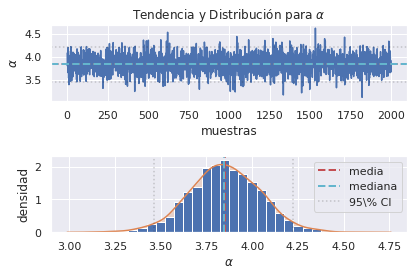

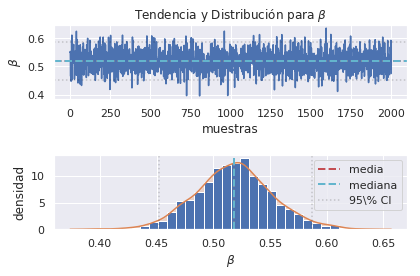

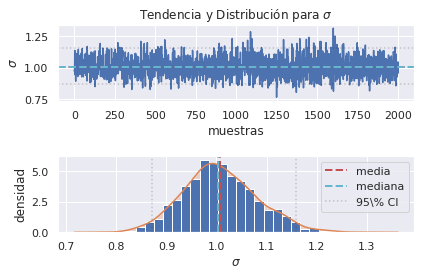

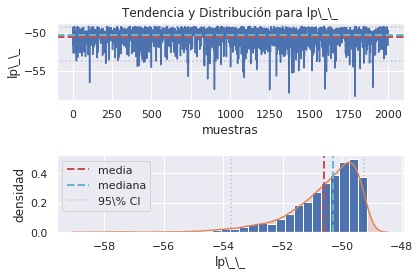

In [14]:
def plot_trace(param, param_name='parameter'):
    """Grafica la tendencia y el posterior de un parámetro."""
    
    # Resumen de estadisticos
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
    
    # Graficando
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel('muestras')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    plt.title('Tendencia y Distribución para {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    plt.xlabel(param_name)
    plt.ylabel('densidad')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label='media')
    plt.axvline(median, color='c', lw=2, linestyle='--',label='mediana')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label=r'95\% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
    
    plt.gcf().tight_layout()
    plt.legend()

plot_trace(alpha, r'$\alpha$') 
plt.show()
plot_trace(beta, r'$\beta$') 
plt.show()
plot_trace(sigma, r'$\sigma$') 
plt.show()
plot_trace(lp, r'lp\_\_') 
plt.show()